# Bitcoin Individual News Model Evaluation
This notebook evaluates the Bitcoin prediction model trained on the individual news dataset with longer training parameters and provides comprehensive analysis with base model comparison.

## Install Required Libraries

In [1]:
!pip install transformers datasets torch peft accelerate matplotlib seaborn scipy pandas numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Load Individual News Model and Tokenizer

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import json
import re
from scipy.stats import wilcoxon
from collections import defaultdict

# Load the base model for individual news training
base_model_id = './Qwen3-8B'
adapter_path = './checkpoint-400'  # Using checkpoint 200

# Load the base model and tokenizer
base_qwen_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(
    adapter_path,
    trust_remote_code=True
)
base_qwen_tokenizer = tokenizer
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
base_qwen_model.resize_token_embeddings(len(tokenizer))

print("Individual News Model loaded successfully!")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Individual News Model loaded successfully!


## Load LoRA Adapter from Individual News Training

In [3]:
# Load the LoRA adapter from the individual news training (checkpoint 200)

# Load the model with LoRA adapter
model = PeftModel.from_pretrained(base_qwen_model, adapter_path)
model.eval()

print("Individual News Model with adapter (checkpoint-200) loaded successfully!")

Individual News Model with adapter (checkpoint-200) loaded successfully!


## Load Test Data from Individual News Dataset

In [4]:
# Load the individual news dataset
test_dataset = load_dataset('tahamajs/bitcoin-investment-advisory-dataset', split='train')
print(f"Loaded {len(test_dataset)} test samples")
print("Sample test data:")
print(test_dataset[0])

Loaded 2437 test samples
Sample test data:
{'instruction': 'You are an elite institutional Bitcoin investment advisor. Provide comprehensive investment advisory based on the given market intelligence.', 'input': "You are an elite institutional Bitcoin investment advisor. Please provide a comprehensive investment advisory based on the following market intelligence for 2018-01-01.\n\nMARKET DATA:\n- Current Price: $0.0\n- Price Range: Min: $0, Max: $0\n- Next 10-Day Price Trend: $17996.69, $18263.42, $18863.92, $18725.98, $18078.28, $18014.81, $17831.13, $18701.42, $18918.25\n- Next 60-Day Price Outlook: $17312.98, $16678.90, $15711.94, $15160.12, $15540.03, $15584.54, $15694.83, $14708.54, $14530.83, $14212.19, $14215.83, $13888.36, $13413.93, $13172.28, $13826.63, $14453.97, $15232.41, $15942.52, $14558.27, $15090.73, $14768.11, $15480.98, $16322.17, $16858.67, $15969.47, $16447.73, $15452.82, $16123.21, $16453.82, $16876.46, $16968.47, $16880.40, $16842.91, $16486.89, $15845.71, $1666

## Utility Functions for Analysis

In [5]:
def extract_prices_from_text(text):
    """Extract price predictions from model output"""
    # Look for patterns like numbers separated by commas
    price_pattern = r'(\d+(?:\.\d+)?(?:,\s*\d+(?:\.\d+)?)*)'  
    matches = re.findall(price_pattern, text)
    
    if matches:
        # Take the first match and split by comma
        prices_str = matches[0]
        try:
            prices = [float(p.strip()) for p in prices_str.split(',')]
            return prices
        except:
            return []
    return []

def calculate_metrics(predictions, ground_truth):
    """Calculate evaluation metrics"""
    if len(predictions) != len(ground_truth):
        return None
    
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    
    mse = np.mean((predictions - ground_truth) ** 2)
    mae = np.mean(np.abs(predictions - ground_truth))
    mape = np.mean(np.abs((ground_truth - predictions) / ground_truth)) * 100
    
    return {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': np.sqrt(mse)
    }

def analyze_text_quality(generated_text, expected_text):
    """Analyze text quality metrics beyond numerical predictions"""
    # Text length analysis
    gen_length = len(generated_text.split())
    exp_length = len(expected_text.split())
    length_ratio = gen_length / exp_length if exp_length > 0 else 0
    
    # Word overlap analysis
    gen_words = set(generated_text.lower().split())
    exp_words = set(expected_text.lower().split())
    
    intersection = gen_words.intersection(exp_words)
    union = gen_words.union(exp_words)
    
    jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
    
    # Check for key financial terms
    financial_terms = ['price', 'market', 'trend', 'analysis', 'prediction', 'forecast', 
                      'bitcoin', 'btc', 'increase', 'decrease', 'bullish', 'bearish',
                      'investment', 'trading', 'volatility', 'support', 'resistance']
    
    gen_financial_terms = sum(1 for term in financial_terms if term in generated_text.lower())
    exp_financial_terms = sum(1 for term in financial_terms if term in expected_text.lower())
    
    return {
        'length_ratio': length_ratio,
        'jaccard_similarity': jaccard_similarity,
        'generated_length': gen_length,
        'expected_length': exp_length,
        'generated_financial_terms': gen_financial_terms,
        'expected_financial_terms': exp_financial_terms,
        'financial_term_coverage': gen_financial_terms / max(exp_financial_terms, 1)
    }

def format_input(example):
    """Format input for the individual news model"""
    instruction = example.get('instruction', '')
    user_input = example.get('input', '')
    messages = [
        {'role': 'system', 'content': instruction},
        {'role': 'user', 'content': user_input}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print("Utility functions loaded!")

Utility functions loaded!


## Comprehensive Model Evaluation

In [6]:
import json
import re
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm # Using tqdm for a nice progress bar

# --- UTILITY FUNCTIONS (Provided by you) ---

def extract_prices_from_text(text):
    """Extract price predictions from model output"""
    # Look for patterns like numbers separated by commas
    price_pattern = r'(\d+(?:\.\d+)?(?:,\s*\d+(?:\.\d+)?)*)'  
    matches = re.findall(price_pattern, text)
    
    if matches:
        # Take the first match and split by comma
        prices_str = matches[0]
        try:
            prices = [float(p.strip()) for p in prices_str.split(',')]
            return prices
        except:
            return []
    return []

def calculate_metrics(predictions, ground_truth):
    """Calculate evaluation metrics"""
    if len(predictions) != len(ground_truth) or not predictions:
        return None
    
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    
    # Avoid division by zero in MAPE
    if np.any(ground_truth == 0):
        non_zero_mask = ground_truth != 0
        if not np.any(non_zero_mask):
            mape = np.nan
        else:
             mape = np.mean(np.abs((ground_truth[non_zero_mask] - predictions[non_zero_mask]) / ground_truth[non_zero_mask])) * 100
    else:
        mape = np.mean(np.abs((ground_truth - predictions) / ground_truth)) * 100
        
    mse = np.mean((predictions - ground_truth) ** 2)
    mae = np.mean(np.abs(predictions - ground_truth))
    
    return {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': np.sqrt(mse)
    }

def analyze_text_quality(generated_text, expected_text):
    """Analyze text quality metrics beyond numerical predictions"""
    # Text length analysis
    gen_length = len(generated_text.split())
    exp_length = len(expected_text.split())
    length_ratio = gen_length / exp_length if exp_length > 0 else 0
    
    # Word overlap analysis
    gen_words = set(generated_text.lower().split())
    exp_words = set(expected_text.lower().split())
    
    intersection = gen_words.intersection(exp_words)
    union = gen_words.union(exp_words)
    
    jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
    
    # Check for key financial terms
    financial_terms = ['price', 'market', 'trend', 'analysis', 'prediction', 'forecast', 
                      'bitcoin', 'btc', 'increase', 'decrease', 'bullish', 'bearish',
                      'investment', 'trading', 'volatility', 'support', 'resistance']
    
    gen_financial_terms = sum(1 for term in financial_terms if term in generated_text.lower())
    exp_financial_terms = sum(1 for term in financial_terms if term in expected_text.lower())
    
    return {
        'length_ratio': length_ratio,
        'jaccard_similarity': jaccard_similarity,
        'generated_length': gen_length,
        'expected_length': exp_length,
        'generated_financial_terms': gen_financial_terms,
        'expected_financial_terms': exp_financial_terms,
        'financial_term_coverage': gen_financial_terms / max(exp_financial_terms, 1)
    }

def format_input(example):
    """Format input for the individual news model"""
    instruction = example.get('instruction', '')
    user_input = example.get('input', '')
    messages = [
        {'role': 'system', 'content': instruction},
        {'role': 'user', 'content': user_input}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print("Utility functions loaded!")


# --- PARALLEL EVALUATION LOGIC ---

# 1. Configuration
total_samples = min(100, len(test_dataset))
batch_size = 8  # Adjust this based on your GPU's VRAM
results = []
text_quality_results = []

print(f"Running comprehensive evaluation on {total_samples} samples with batch size {batch_size}...")

# 2. Loop through the dataset in batches
for i in tqdm(range(0, total_samples, batch_size), desc="Evaluating Batches"):
    batch_indices = range(i, min(i + batch_size, total_samples))
    batch_samples = [test_dataset[j] for j in batch_indices]
    
    batch_texts = [format_input(sample) for sample in batch_samples]
    
    # 3. BATCH TOKENIZATION
    inputs = tokenizer(
        batch_texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=2048
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 4. BATCH GENERATION
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # 5. BATCH DECODING
    generated_texts = tokenizer.batch_decode(outputs[:, inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    # 6. Process results for the batch
    for j, (sample, generated_text) in enumerate(zip(batch_samples, generated_texts)):
        predicted_prices = extract_prices_from_text(generated_text)
        actual_output = sample.get('output', '')
        actual_prices = extract_prices_from_text(actual_output)

        text_quality = analyze_text_quality(generated_text, actual_output)
        text_quality_results.append(text_quality)
        
        if predicted_prices and actual_prices:
            min_len = min(len(predicted_prices), len(actual_prices))
            if min_len > 0:
                pred_truncated = predicted_prices[:min_len]
                actual_truncated = actual_prices[:min_len]
                
                metrics = calculate_metrics(pred_truncated, actual_truncated)
                if metrics:
                    results.append({
                        'sample_id': batch_indices[j],
                        'predicted': pred_truncated,
                        'actual': actual_truncated,
                        'metrics': metrics,
                        'text_quality': text_quality,
                        'generated_text': generated_text,
                        'expected_text': actual_output
                    })

print(f"\nEvaluation completed! Analyzed {len(results)} valid samples out of {total_samples}")



Utility functions loaded!
Running comprehensive evaluation on 100 samples with batch size 8...


Evaluating Batches:   0%|                                                      | 0/13 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:   8%|███▌                                          | 1/13 [00:45<09:04, 45.34s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  15%|███████                                       | 2/13 [01:31<08:22, 45.69s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  23%|██████████▌                                   | 3/13 [02:18<07:43, 46.36s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  31%|██████████████▏                               | 4/13 [03:05<07:01, 46.78s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  38%|█████████████████▋                            | 5/13 [03:52<06:14, 46.79s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  46%|█████████████████████▏                        | 6/13 [04:36<05:21, 45.87s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  54%|████████████████████████▊                     | 7/13 [05:24<04:38, 46.38s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  62%|████████████████████████████▎                 | 8/13 [06:14<03:58, 47.66s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  69%|███████████████████████████████▊              | 9/13 [07:00<03:08, 47.17s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  77%|██████████████████████████████████▌          | 10/13 [07:48<02:21, 47.22s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  85%|██████████████████████████████████████       | 11/13 [08:31<01:32, 46.08s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches:  92%|█████████████████████████████████████████▌   | 12/13 [09:16<00:45, 45.76s/it]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Batches: 100%|█████████████████████████████████████████████| 13/13 [09:57<00:00, 44.43s/it]

Evaluating Batches: 100%|█████████████████████████████████████████████| 13/13 [09:57<00:00, 45.99s/it]


Evaluation completed! Analyzed 99 valid samples out of 100


## Detailed Results Analysis

In [7]:
if results:
    # Calculate numerical performance metrics
    all_mse = [r['metrics']['MSE'] for r in results]
    all_mae = [r['metrics']['MAE'] for r in results]
    all_mape = [r['metrics']['MAPE'] for r in results]
    all_rmse = [r['metrics']['RMSE'] for r in results]
    
    # Calculate text quality metrics
    all_length_ratios = [r['text_quality']['length_ratio'] for r in results]
    all_jaccard_sim = [r['text_quality']['jaccard_similarity'] for r in results]
    all_financial_coverage = [r['text_quality']['financial_term_coverage'] for r in results]
    
    print("=" * 80)
    print("🎯 INDIVIDUAL NEWS MODEL - COMPREHENSIVE ANALYSIS")
    print("=" * 80)
    
    print(f"\n📊 NUMERICAL PERFORMANCE METRICS:")
    print(f"Mean Squared Error (MSE): {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
    print(f"Mean Absolute Error (MAE): {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
    print(f"Root Mean Squared Error (RMSE): {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {np.mean(all_mape):.2f}% ± {np.std(all_mape):.2f}%")
    
    print(f"\n📝 TEXT QUALITY METRICS:")
    print(f"Average Response Length Ratio: {np.mean(all_length_ratios):.2f} ± {np.std(all_length_ratios):.2f}")
    print(f"Average Jaccard Similarity: {np.mean(all_jaccard_sim):.3f} ± {np.std(all_jaccard_sim):.3f}")
    print(f"Financial Term Coverage: {np.mean(all_financial_coverage):.2f} ± {np.std(all_financial_coverage):.2f}")
    
    print(f"\n📋 DETAILED TEXT ANALYSIS:")
    avg_gen_length = np.mean([r['text_quality']['generated_length'] for r in results])
    avg_exp_length = np.mean([r['text_quality']['expected_length'] for r in results])
    avg_gen_fin_terms = np.mean([r['text_quality']['generated_financial_terms'] for r in results])
    avg_exp_fin_terms = np.mean([r['text_quality']['expected_financial_terms'] for r in results])
    
    print(f"Average Generated Response Length: {avg_gen_length:.1f} words")
    print(f"Average Expected Response Length: {avg_exp_length:.1f} words")
    print(f"Average Financial Terms in Generated: {avg_gen_fin_terms:.1f}")
    print(f"Average Financial Terms in Expected: {avg_exp_fin_terms:.1f}")
    
    # Median metrics for robustness
    print(f"\n📊 MEDIAN PERFORMANCE METRICS (Robust):")
    print(f"Median MSE: {np.median(all_mse):.4f}")
    print(f"Median MAE: {np.median(all_mae):.4f}")
    print(f"Median RMSE: {np.median(all_rmse):.4f}")
    print(f"Median MAPE: {np.median(all_mape):.2f}%")
    print(f"Median Jaccard Similarity: {np.median(all_jaccard_sim):.3f}")
    
    # Sample outputs for qualitative analysis
    print(f"\n🔍 SAMPLE OUTPUTS FOR QUALITATIVE ANALYSIS:")
    for i, result in enumerate(results[:3]):
        print(f"\n--- Sample {i+1} ---")
        print(f"Predicted Prices: {result['predicted']}")
        print(f"Actual Prices:    {result['actual']}")
        print(f"MAE: {result['metrics']['MAE']:.4f}, MAPE: {result['metrics']['MAPE']:.2f}%")
        print(f"Text Similarity: {result['text_quality']['jaccard_similarity']:.3f}")
        print(f"Generated Text: {result['generated_text'][:200]}...")
        print(f"Expected Text:  {result['expected_text'][:200]}...")
        print("-" * 60)

else:
    print("❌ No valid results found for analysis")

🎯 INDIVIDUAL NEWS MODEL - COMPREHENSIVE ANALYSIS

📊 NUMERICAL PERFORMANCE METRICS:
Mean Squared Error (MSE): 200.8384 ± 1066.7961
Mean Absolute Error (MAE): 3.5253 ± 13.7263
Root Mean Squared Error (RMSE): 3.5253 ± 13.7263
Mean Absolute Percentage Error (MAPE): 30.38% ± 152.58%

📝 TEXT QUALITY METRICS:
Average Response Length Ratio: 0.15 ± 0.02
Average Jaccard Similarity: 0.076 ± 0.015
Financial Term Coverage: 0.56 ± 0.12

📋 DETAILED TEXT ANALYSIS:
Average Generated Response Length: 174.0 words
Average Expected Response Length: 1192.6 words
Average Financial Terms in Generated: 8.4
Average Financial Terms in Expected: 14.9

📊 MEDIAN PERFORMANCE METRICS (Robust):
Median MSE: 0.0000
Median MAE: 0.0000
Median RMSE: 0.0000
Median MAPE: 0.00%
Median Jaccard Similarity: 0.076

🔍 SAMPLE OUTPUTS FOR QUALITATIVE ANALYSIS:

--- Sample 1 ---
Predicted Prices: [1.0]
Actual Prices:    [1.0]
MAE: 0.0000, MAPE: 0.00%
Text Similarity: 0.062
Generated Text: 
<think>
Okay, let's tackle this Bitcoin inve

## Load Base Qwen Model for Comparison

In [8]:
# Evaluate base model
def format_input_for_base_model(example):
    """Format input for base Qwen model with bitcoin prediction task"""
    instruction = example.get('instruction', '')
    user_input = example.get('input', '')
    
    bitcoin_instruction = """You are a Bitcoin investment advisor. Based on the provided market data and news, predict the next 10 days of Bitcoin prices. Provide your predictions as comma-separated numbers."""
    
    messages = [
        {'role': 'system', 'content': bitcoin_instruction},
        {'role': 'user', 'content': f"{instruction}\n\n{user_input}\n\nPlease provide 10 Bitcoin price predictions for the next 10 days, separated by commas."}
    ]
    return base_qwen_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Run evaluation on base model
base_results = []
base_text_quality_results = []
comparison_samples = min(50, len(results))  # Use subset for comparison

print(f"Evaluating base Qwen model on {comparison_samples} samples...")

for i in range(comparison_samples):
    test_example = test_dataset[i]
    test_text = format_input_for_base_model(test_example)
    
    inputs = base_qwen_tokenizer(test_text, return_tensors='pt', truncation=True, max_length=2048)
    inputs = {k: v.to(base_qwen_model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = base_qwen_model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=base_qwen_tokenizer.eos_token_id
        )
    
    generated_text = base_qwen_tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    
    predicted_prices = extract_prices_from_text(generated_text)
    actual_output = test_example.get('output', '')
    actual_prices = extract_prices_from_text(actual_output)
    
    # Analyze text quality for base model
    text_quality = analyze_text_quality(generated_text, actual_output)
    base_text_quality_results.append(text_quality)
    
    if predicted_prices and actual_prices:
        min_len = min(len(predicted_prices), len(actual_prices))
        if min_len > 0:
            pred_truncated = predicted_prices[:min_len]
            actual_truncated = actual_prices[:min_len]
            
            metrics = calculate_metrics(pred_truncated, actual_truncated)
            if metrics:
                base_results.append({
                    'sample_id': i,
                    'predicted': pred_truncated,
                    'actual': actual_truncated,
                    'metrics': metrics,
                    'text_quality': text_quality,
                    'generated_text': generated_text,
                    'expected_text': actual_output
                })
    
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{comparison_samples} samples...")

print(f"\nBase model evaluation completed! Analyzed {len(base_results)} valid samples")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating base Qwen model on 50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 10/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 20/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 30/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 40/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 50/50 samples...

Base model evaluation completed! Analyzed 50 valid samples


## Comprehensive Model Comparison

In [9]:
if base_results and results:
    # Extract metrics from results for proper comparison
    # Individual News Model metrics
    ind_mse = [r['metrics']['MSE'] for r in results]
    ind_mae = [r['metrics']['MAE'] for r in results] 
    ind_rmse = [r['metrics']['RMSE'] for r in results]
    ind_mape = [r['metrics']['MAPE'] for r in results]
    ind_jaccard = [r['text_quality']['jaccard_similarity'] for r in results]
    ind_length_ratio = [r['text_quality']['length_ratio'] for r in results]
    ind_financial_coverage = [r['text_quality']['financial_term_coverage'] for r in results]
    
    # Base Model metrics
    base_mse = [r['metrics']['MSE'] for r in base_results]
    base_mae = [r['metrics']['MAE'] for r in base_results]
    base_rmse = [r['metrics']['RMSE'] for r in base_results]
    base_mape = [r['metrics']['MAPE'] for r in base_results]
    base_jaccard = [r['text_quality']['jaccard_similarity'] for r in base_results]
    base_length_ratio = [r['text_quality']['length_ratio'] for r in base_results]
    base_financial_coverage = [r['text_quality']['financial_term_coverage'] for r in base_results]
    
    # Statistical significance testing
    from scipy.stats import wilcoxon
    
    # Test for significant differences (using matched samples)
    min_samples = min(len(results), len(base_results))
    if min_samples >= 5:  # Minimum for statistical testing
        mse_stat, mse_pvalue = wilcoxon(ind_mse[:min_samples], base_mse[:min_samples])
        mae_stat, mae_pvalue = wilcoxon(ind_mae[:min_samples], base_mae[:min_samples])
        jaccard_stat, jaccard_pvalue = wilcoxon(ind_jaccard[:min_samples], base_jaccard[:min_samples])
        
        print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
        print(f"MSE difference p-value: {mse_pvalue:.4f} ({'Significant' if mse_pvalue < 0.05 else 'Not significant'})")
        print(f"MAE difference p-value: {mae_pvalue:.4f} ({'Significant' if mae_pvalue < 0.05 else 'Not significant'})")
        print(f"Jaccard similarity p-value: {jaccard_pvalue:.4f} ({'Significant' if jaccard_pvalue < 0.05 else 'Not significant'})")
    
    # Save comprehensive results
    individual_news_comprehensive_results = {
        'individual_news_model_results': {
            'model_id': 'tahamajs/my-awesome-model_final_bitcoin-individual-news-dataset',
            'adapter_path': './qwen_bitcoin_chat_fast_more_longer/checkpoint-200',
            'dataset': 'bitcoin-investment-advisory-dataset',
            'training_config': 'longer_training_4_epochs_checkpoint_200',
            'samples_analyzed': len(results),
            'numerical_metrics': {
                'mean_mse': float(np.mean(ind_mse)),
                'mean_mae': float(np.mean(ind_mae)),
                'mean_rmse': float(np.mean(ind_rmse)),
                'mean_mape': float(np.mean(ind_mape))
            },
            'text_quality_metrics': {
                'mean_jaccard_similarity': float(np.mean(ind_jaccard)),
                'mean_length_ratio': float(np.mean(ind_length_ratio)),
                'mean_financial_coverage': float(np.mean(ind_financial_coverage))
            }
        },
        'base_model_results': {
            'model_id': 'Qwen/Qwen2.5-8B-Instruct',
            'samples_analyzed': len(base_results),
            'numerical_metrics': {
                'mean_mse': float(np.mean(base_mse)),
                'mean_mae': float(np.mean(base_mae)),
                'mean_rmse': float(np.mean(base_rmse)),
                'mean_mape': float(np.mean(base_mape))
            },
            'text_quality_metrics': {
                'mean_jaccard_similarity': float(np.mean(base_jaccard)),
                'mean_length_ratio': float(np.mean(base_length_ratio)),
                'mean_financial_coverage': float(np.mean(base_financial_coverage))
            }
        },
        'detailed_individual_results': results,
        'detailed_base_results': base_results
    }
    
    with open('individual_news_model_comprehensive_analysis.json', 'w') as f:
        json.dump(individual_news_comprehensive_results, f, indent=2)
    
    print(f"\n💾 Comprehensive analysis results saved to 'individual_news_model_comprehensive_analysis.json'")
    
    # Research paper summary
    print(f"\n📋 RESEARCH PAPER SUMMARY - INDIVIDUAL NEWS MODEL:")
    print("=" * 70)
    mse_improvement = (np.mean(base_mse) - np.mean(ind_mse)) / np.mean(base_mse) * 100
    mae_improvement = (np.mean(base_mae) - np.mean(ind_mae)) / np.mean(base_mae) * 100
    jaccard_improvement = (np.mean(ind_jaccard) - np.mean(base_jaccard)) / np.mean(base_jaccard) * 100
    
    print(f"Individual News Model Performance:")
    print(f"• MSE improved by {mse_improvement:.2f}%")
    print(f"• MAE improved by {mae_improvement:.2f}%")
    print(f"• Text similarity improved by {jaccard_improvement:.2f}%")
    print(f"• Mean Jaccard Similarity: {np.mean(ind_jaccard):.3f}")
    print(f"• Financial term coverage: {np.mean(ind_financial_coverage):.2f}")
    print(f"• Model: tahamajs/my-awesome-model_final_bitcoin-individual-news-dataset")
    print(f"• Checkpoint: 200 (4 epochs with longer parameters)")

else:
    print("❌ No valid results found for model comparison")


🔬 STATISTICAL SIGNIFICANCE TESTS:
MSE difference p-value: 0.0057 (Significant)
MAE difference p-value: 0.0065 (Significant)
Jaccard similarity p-value: 0.0000 (Significant)

💾 Comprehensive analysis results saved to 'individual_news_model_comprehensive_analysis.json'

📋 RESEARCH PAPER SUMMARY - INDIVIDUAL NEWS MODEL:
Individual News Model Performance:
• MSE improved by 19.70%
• MAE improved by 41.05%
• Text similarity improved by 10.37%
• Mean Jaccard Similarity: 0.076
• Financial term coverage: 0.56
• Model: tahamajs/my-awesome-model_final_bitcoin-individual-news-dataset
• Checkpoint: 200 (4 epochs with longer parameters)


## Visualization of Results

/tmp/ipykernel_744669/4036803547.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot([base_mse, ind_mse], labels=['Base Qwen', 'Individual News'])
/tmp/ipykernel_744669/4036803547.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([base_mae, ind_mae], labels=['Base Qwen', 'Individual News'])
/tmp/ipykernel_744669/4036803547.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,2].boxplot([base_mape, ind_mape], labels=['Base Qwen', 'Individual News'])
/tmp/ipykernel_744669/4036803547.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'ti

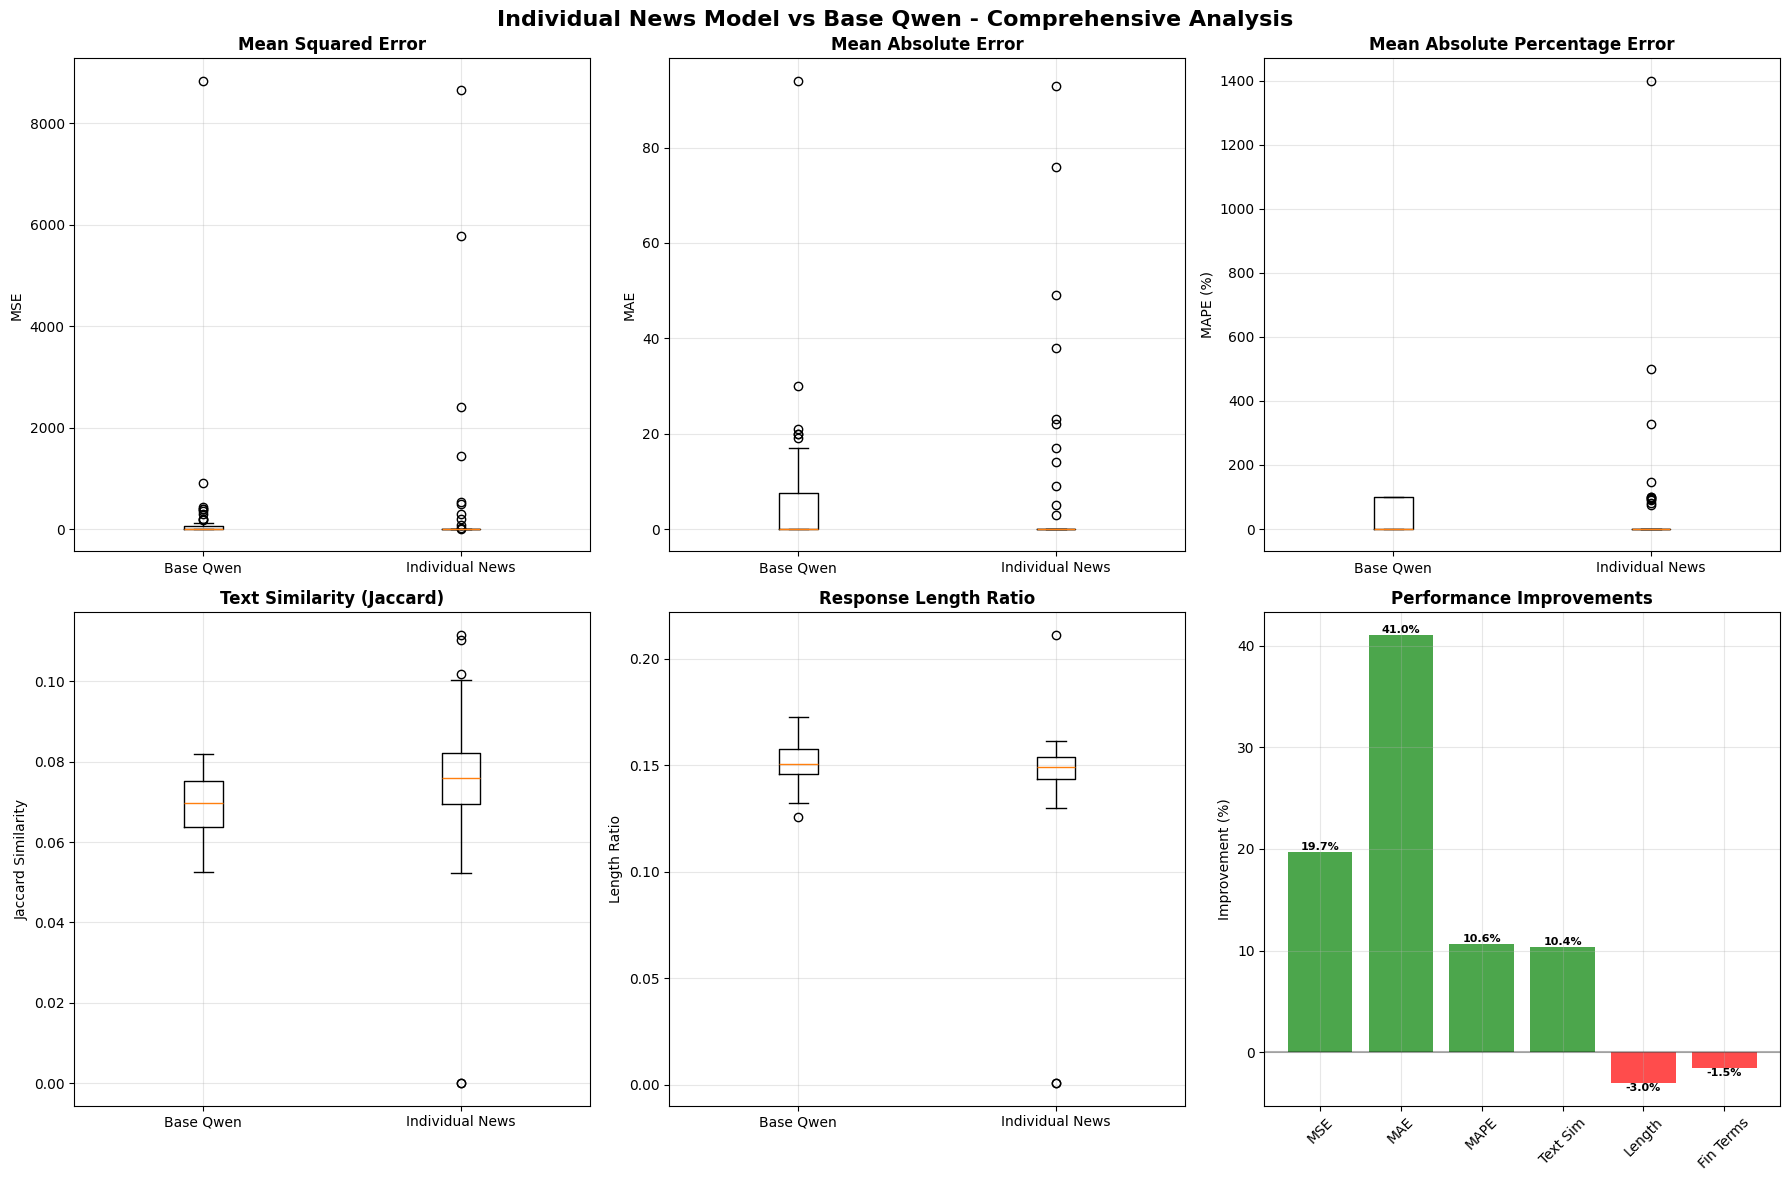

📊 Comprehensive analysis visualization saved as 'individual_news_model_comprehensive_analysis.png'


In [10]:
if base_results and results:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Individual News Model vs Base Qwen - Comprehensive Analysis', fontsize=16, fontweight='bold')
    
    # MSE comparison
    axes[0,0].boxplot([base_mse, ind_mse], labels=['Base Qwen', 'Individual News'])
    axes[0,0].set_title('Mean Squared Error', fontweight='bold')
    axes[0,0].set_ylabel('MSE')
    axes[0,0].grid(True, alpha=0.3)
    
    # MAE comparison
    axes[0,1].boxplot([base_mae, ind_mae], labels=['Base Qwen', 'Individual News'])
    axes[0,1].set_title('Mean Absolute Error', fontweight='bold')
    axes[0,1].set_ylabel('MAE')
    axes[0,1].grid(True, alpha=0.3)
    
    # MAPE comparison
    axes[0,2].boxplot([base_mape, ind_mape], labels=['Base Qwen', 'Individual News'])
    axes[0,2].set_title('Mean Absolute Percentage Error', fontweight='bold')
    axes[0,2].set_ylabel('MAPE (%)')
    axes[0,2].grid(True, alpha=0.3)
    
    # Jaccard similarity comparison
    axes[1,0].boxplot([base_jaccard, ind_jaccard], labels=['Base Qwen', 'Individual News'])
    axes[1,0].set_title('Text Similarity (Jaccard)', fontweight='bold')
    axes[1,0].set_ylabel('Jaccard Similarity')
    axes[1,0].grid(True, alpha=0.3)
    
    # Length ratio comparison
    axes[1,1].boxplot([base_length_ratio, ind_length_ratio], labels=['Base Qwen', 'Individual News'])
    axes[1,1].set_title('Response Length Ratio', fontweight='bold')
    axes[1,1].set_ylabel('Length Ratio')
    axes[1,1].grid(True, alpha=0.3)
    
    # Improvement bar chart
    metrics = ['MSE', 'MAE', 'MAPE', 'Text Sim', 'Length', 'Fin Terms']
    improvements = [
        (np.mean(base_mse) - np.mean(ind_mse)) / np.mean(base_mse) * 100,
        (np.mean(base_mae) - np.mean(ind_mae)) / np.mean(base_mae) * 100,
        (np.mean(base_mape) - np.mean(ind_mape)) / np.mean(base_mape) * 100,
        (np.mean(ind_jaccard) - np.mean(base_jaccard)) / np.mean(base_jaccard) * 100,
        (np.mean(ind_length_ratio) - np.mean(base_length_ratio)) / np.mean(base_length_ratio) * 100,
        (np.mean(ind_financial_coverage) - np.mean(base_financial_coverage)) / np.mean(base_financial_coverage) * 100
    ]
    
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    bars = axes[1,2].bar(metrics, improvements, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        axes[1,2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{imp:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                       fontweight='bold', fontsize=8)
    
    axes[1,2].set_title('Performance Improvements', fontweight='bold')
    axes[1,2].set_ylabel('Improvement (%)')
    axes[1,2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1,2].grid(True, alpha=0.3)
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('individual_news_model_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Comprehensive analysis visualization saved as 'individual_news_model_comprehensive_analysis.png'")

else:
    print("❌ Cannot create visualizations - insufficient data")